In [41]:
import torch, torchvision
import numpy as np
import os 
import PIL
import pdb
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [42]:
def show(tensor, num=25, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[: num], nrow =5).permute(1, 2,0)
    plt.imshow(grid.clip(0, 1))
    plt.title(name)
    plt.show()

In [43]:
n_epochs=10000
batch_size=128
lr=1e-4
z_dim=200
device='cuda' 

cur_step=0
crit_cycles=5
gen_losses=[]
crit_losses=[]
show_step=156
save_step=156

wandbact=1 


In [44]:


class Generator(nn.Module):
  def __init__(self, z_dim=64, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim=z_dim

    self.gen = nn.Sequential(
 
            nn.BatchNorm2d(d_dim*32),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), 
            nn.BatchNorm2d(d_dim*16),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), 

            nn.BatchNorm2d(d_dim*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*8, d_dim*2, 4, 2, 1), 
            nn.BatchNorm2d(d_dim*2),
            nn.ReLU(True),            

            nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1),
            nn.Tanh() )

  def forward(self, noise):
    x=noise.view(len(noise), self.z_dim, 1, 1) 
    return self.gen(x)


def gen_noise(num, z_dim, device='cuda'):
   return torch.randn(num, z_dim, device=device) 



In [45]:

class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(

      nn.Conv2d(3, d_dim, 4, 2, 1),
      nn.InstanceNorm2d(d_dim), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), 
      nn.InstanceNorm2d(d_dim*2), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), 
      nn.InstanceNorm2d(d_dim*4), 
      nn.LeakyReLU(0.2),
              
      nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1),
      nn.InstanceNorm2d(d_dim*8), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), 
      nn.InstanceNorm2d(d_dim*16), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*16, 1, 2, 1, 0), 

    )


  def forward(self, image):

    crit_pred = self.crit(image) 
    return crit_pred.view(len(crit_pred),-1)
  

In [46]:
path = 'F:/datasets/anime_faces'

In [47]:
class Dataset(Dataset):
    def __init__(self, path, size=64, lim=20000):
        self.sizes = [size, size]
        self.path = path
        self.lim = lim
        
        items, labels=[], []
        
        for data in os.listdir(path)[:lim]:
            item = os.path.join(path, data)
            items.append(item)
            labels.append(data) 
            
        self.items = items
        self.labels = labels
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
         data = PIL.Image.open(self.items[idx]).convert('RGB')  
         data = np.asarray(torchvision.transforms.Resize(self.sizes)(data))
         data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False)
         data = torch.from_numpy(data).div(255)
         return data, self.labels[idx]
         

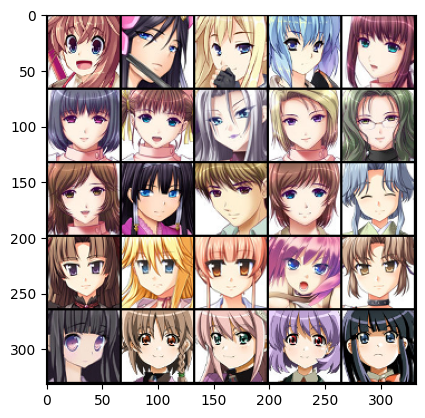

In [48]:
ds = Dataset(path=path, size=64, lim=20000)
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=True)
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

x, y = next(iter(dataloader))
show(x)

In [49]:
def get_gp(real, fake, crit, alpha, gamma=10):
    mix_images = alpha * real + (1-alpha) * fake 
    mix_scores = crit(mix_images)
    gradient = torch.autograd.grad(
        inputs = mix_images,
        outputs = mix_scores,
        grad_outputs = torch.ones_like(mix_scores),
        retain_graph = True,
        create_graph = True
    )[0]
    
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    gp = gamma * ((gradient_norm) ** 2).mean()
    
    return gp
    

In [50]:
root_path = 'F:/Python/proyectos/Generative/WGAN/'
def save_checkpoint(name):
    torch.save({
        'epoch': epoch,
        'model_state': gen.state_dict(),
        'optimizer_state_dict': gen_opt.state_dict()
    }, f'{root_path}G-{name}.pkl')
    
    torch.save({
        'epoch': epoch,
        'model_state': crit.state_dict(),
        'optimizer_state_dict': crit_opt.state_dict()
    }, f'{root_path}C-{name}.pkl')
    
    print('Model has been saved!')
    

def load_checkpoint(gen_path, crit_path):
  checkpoint = torch.load(gen_path)
  gen.load_state_dict(checkpoint['model_state'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(crit_path)
  crit.load_state_dict(checkpoint['model_state'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Checkpoint Loaded")


In [51]:
load_checkpoint("F:/Python/proyectos/Generative/WGAN/G-latest.pkl", "F:/Python/proyectos/Generative/WGAN/C-latest.pkl")

Checkpoint Loaded


  0%|          | 0/156 [00:00<?, ?it/s]

Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100
Step: 110
Step: 120
Step: 130
Step: 140
Step: 150


  0%|          | 0/156 [00:00<?, ?it/s]

Saving Checkpoint...
Model has been saved!


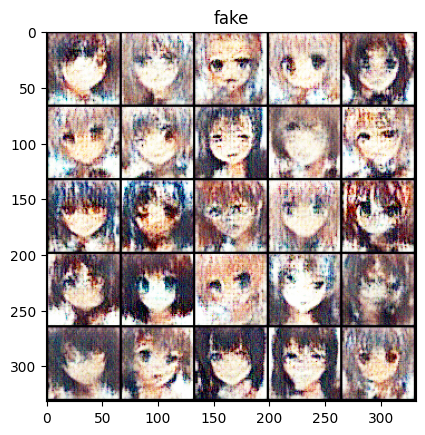

Epoch: 1 | Step 156
Step: 160
Step: 170


KeyboardInterrupt: 

In [52]:
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_bs = len(real)
        real = real.to(device)
        
        mean_crit_loss = 0
        
        for _ in range(crit_cycles):
            crit_opt.zero_grad()
            noise = gen_noise(cur_bs, z_dim)
            fake = gen(noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)
            
            alpha = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gp = get_gp(real, fake.detach(), crit, alpha=alpha)
            
            crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp
            
            mean_crit_loss += crit_loss.item() / crit_cycles
            
            crit_loss.backward(retain_graph=True)
            
            crit_opt.step()
        
        crit_losses += [mean_crit_loss]
        
        #Generator
        
        gen_opt.zero_grad()
        noise = gen_noise(cur_bs, z_dim)
        fake = gen(noise)
        
        crit_fake_pred = crit(fake)
        
        gen_loss = -crit_fake_pred.mean()
        gen_loss.backward()
        gen_opt.step()
        gen_losses += [gen_loss.item()]
        
        if (cur_step % save_step == 0 and cur_step > 0):
            print('Saving Checkpoint...')
            save_checkpoint('latest')
            
        if (cur_step % show_step == 0 and cur_step > 0):
            show(fake, name='fake')
        
            print(f'Epoch: {epoch} | Step {cur_step}')
        
        if cur_step % 10 == 0:
            print(f'Step: {cur_step}')
        cur_step+=1

        